#**Weather Classification**

<img src=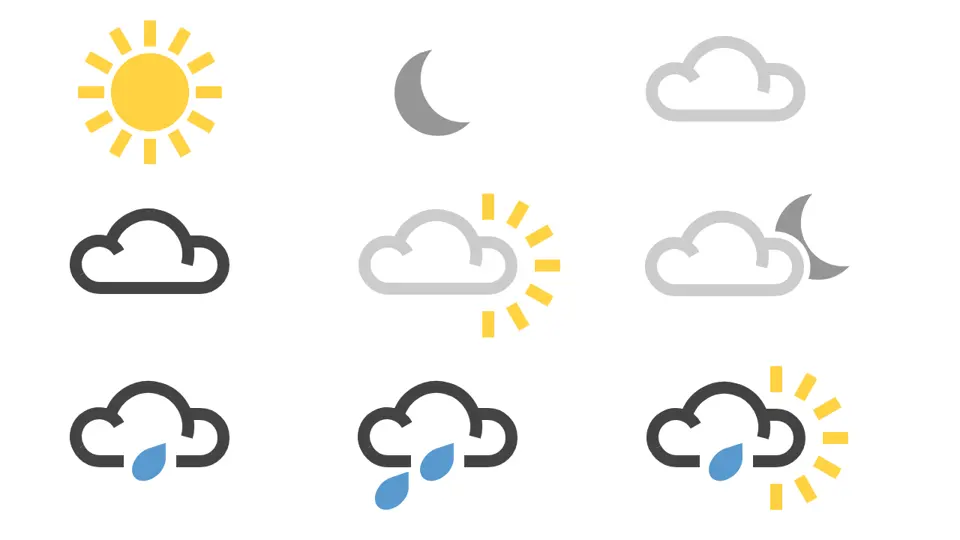 width="250">

This notebook trains and tests a neural network to classify images of weather conditions into 4 classes: Cloudy, Rain, Shine, Sunrise.

VGG16 convolutional features are used for transfer learning, and a feed-forward network is trained to label weather images with over 98% accuracy.

Weather images available at: https://data.mendeley.com/datasets/4drtyfjtfy/1

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Import libraries
from collections import namedtuple
import copy, math, os, sys, torch
import matplotlib.pyplot as plt
import numpy as np
from operator import add
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score
from torch import Tensor, nn, optim
import torch.nn.functional as F
import torchvision.utils
from torchvision.models import vgg
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

In [3]:
# Connect to GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


**Analyse contents of dataset**

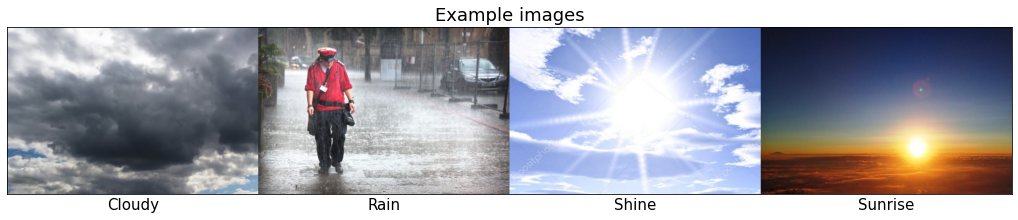

In [5]:
classes = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

cloudy_img = Image.open('WeatherImages/cloudy/cloudy18.jpg')
rain_img = Image.open('WeatherImages/rain/rain20.jpg')
shine_img = Image.open('WeatherImages/shine/shine18.jpg')
sunrise_img = Image.open('WeatherImages/sunrise/sunrise3.jpg')
example_imgs = [cloudy_img, rain_img, shine_img, sunrise_img]

w, h = example_imgs[1].size
grid = Image.new('RGBA', size=(4*w, h))
grid_w, grid_h = grid.size
ls = grid_w/4   # label spacing

for i, img in enumerate(example_imgs):
    grid.paste(img, box=(i%4*w, i//4*h))

plt.figure(figsize=(18,10))
plt.title('Example images', fontsize=18)
plt.imshow(grid)
plt.xticks([ls-ls/2, ls*2-ls/2, ls*3-ls/2, ls*4-ls/2], classes, fontsize=15)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.yticks([])
plt.show()

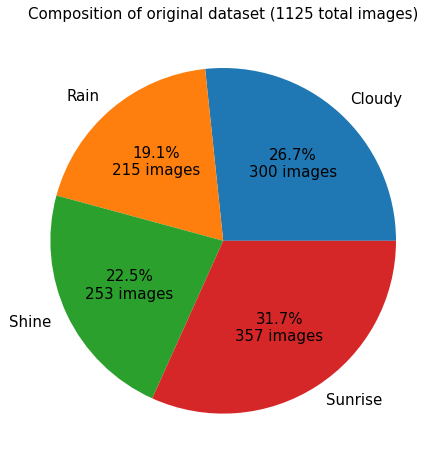

In [6]:
# Check number of images for each type of weather condition
num_cloudy = len(os.listdir('WeatherImages/cloudy/'))
num_rain = len(os.listdir('WeatherImages/rain/'))
num_shine = len(os.listdir('WeatherImages/shine/'))
num_sunrise = len(os.listdir('WeatherImages/sunrise/'))

# Plot distribution of classes
def label_pie(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n{:d} images".format(pct, absolute)

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
weather_conditions = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
num_images = [num_cloudy,num_rain,num_shine,num_sunrise]
ax.pie(num_images, labels = weather_conditions, autopct=lambda pct: label_pie(pct, num_images), textprops={'fontsize': 15})
plt.title('Composition of original dataset ({} total images)'.format(sum(num_images)), fontsize=15)
plt.show()

**Load complete dataset and split into train, val, test**

In [7]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

# Load data onto GPU if available
def preprocess(x, y):
    return x.to(dev), y.to(dev)

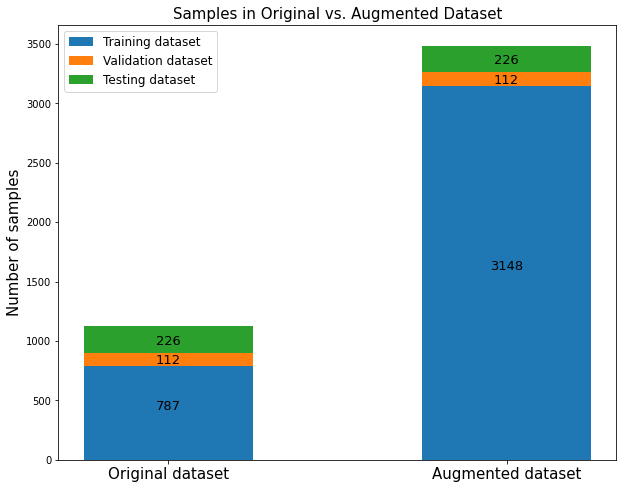

In [8]:
# Load original dataset, split into train, val, test
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
original_dataset = datasets.ImageFolder('WeatherImages/', transform = transformations)
og_trn_size = int(0.7 * len(original_dataset))
og_val_size = int(0.1 * len(original_dataset))
og_tst_size = len(original_dataset) - og_trn_size - og_val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(original_dataset, [og_trn_size, og_val_size, og_tst_size])

# Use data augmentation to increase number of training samples
augment_train_ds1 = copy.deepcopy(train_ds)
augment_train_ds1.dataset.transform = transforms.Compose([transforms.Resize(255),
                                                         transforms.RandomCrop(224),
                                                         transforms.RandomHorizontalFlip(p=1),
                                                         transforms.ToTensor()])
augment_train_ds2 = copy.deepcopy(train_ds)
augment_train_ds2.dataset.transform = transforms.Compose([transforms.Resize(255),
                                                         transforms.RandomCrop(224),
                                                         transforms.RandomRotation(25),
                                                         transforms.ToTensor()])
augment_train_ds3 = copy.deepcopy(train_ds)                  
augment_train_ds3.dataset.transform = transforms.Compose([transforms.Resize(255),
                                        transforms.RandomCrop(224),
                                        transforms.RandomPerspective(distortion_scale=0.5, p=1),
                                        transforms.ToTensor()])

train_ds = torch.utils.data.ConcatDataset([train_ds, augment_train_ds1])
train_ds = torch.utils.data.ConcatDataset([train_ds, augment_train_ds2])
train_ds = torch.utils.data.ConcatDataset([train_ds, augment_train_ds3])

# Create dataloaders
bs = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=len(val_ds))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds))
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

# Plot size of datasets in bar chart
labels = ['Original dataset', 'Augmented dataset']
train_nos = [og_trn_size, len(train_ds)]
val_nos = [og_val_size, len(val_ds)]
test_nos = [og_tst_size, len(test_ds)]
width = 0.5
fig, ax = plt.subplots(figsize=(10,8))
trn_bars = ax.bar(labels, train_nos, width, label='Training dataset')
val_bars = ax.bar(labels, val_nos, width, bottom=train_nos, label='Validation dataset')
tst_bars = ax.bar(labels, test_nos, width, bottom=list(map(add, train_nos, val_nos)), label='Testing dataset')
for i in range(len(trn_bars)):
    ax.annotate(str(train_nos[i]), xy=(labels[i],train_nos[i]/2), ha='center', va='bottom', fontsize='13')
    ax.annotate(str(val_nos[i]), xy=(labels[i],val_nos[i]/2+train_nos[i]-63), ha='center', va='bottom', fontsize='13')
    ax.annotate(str(test_nos[i]), xy=(labels[i],test_nos[i]/2+list(map(add, train_nos, val_nos))[i]-65), ha='center', va='bottom', fontsize='13')
ax.set_ylabel('Number of samples', fontsize='15')
ax.set_title('Samples in Original vs. Augmented Dataset', fontsize='15')
ax.set_xticklabels(labels, fontsize='15')
ax.legend(fontsize='12')
plt.show()

**Define training functions**

In [9]:
# Calculate loss for each batch and backpropagate this through the network
def loss_batch(model, conv_network, loss_func, xb, yb, opt=None):

    # Use pretarined cnn to extract features
    conv_features = conv_network(xb)[4]

    # Train classifier on features of pretrained network convolutional layer
    predictions = model(conv_features)
    labels = yb

    criterion = loss_func
    loss = criterion(predictions, labels)

    if opt != None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Calculate batch accuracy
    confidence, predicted = torch.max(predictions.data, 1)
    correct = (predicted == labels).sum().item()

    return loss.item(), correct, labels.size(0)

In [10]:
# Train model
def train(epochs, model, conv_network, loss_func, opt, train_dl, valid_dl, batches):
   
    # Lists to track training progress
    train_losses = []
    validation_losses = []
    train_accs = []
    validation_accs = []
    
    print('Training progress:')
    for epoch in tqdm(range(epochs)):   # Show progress bar with tqdm
        
        # print('Epoch {}/{}'.format(epoch+1, epochs))      
        batch = 1        
        model.train()
        correct = 0
        loss = 0
        samples = 0

        # Iterate through batches, train model
        for xb, yb in train_dl:
            batch_loss, batch_correct, batch_size = loss_batch(model, conv_network, loss_func, xb, yb, opt)
            loss += batch_loss
            correct += batch_correct
            samples += batch_size
            batch+=1     

        train_acc = correct/samples
        loss = loss/len(train_dl)

        # Use validation data to check for overfitting
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[loss_batch(model, conv_network, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(corrects) / np.sum(nums)

        train_losses.append(loss)
        validation_losses.append(val_loss)
        train_accs.append(train_acc)
        validation_accs.append(val_acc)

        # print('loss = {}      accuracy = {}      val_loss = {}      val_accuracy: {}'.format(loss, train_acc, val_loss, val_acc))

    print('Final training loss =   {}      final training accuracy =   {}'.format(loss, train_acc))
    print('Final validation loss = {}      final validation accuracy = {}'.format(val_loss, val_acc))

    # Save state dict for future loading of trained model
    torch.save(model.state_dict(), '/content/drive/My Drive/WeatherClassificationModels/classifier_{}'.format(epoch+1))
    torch.save(opt.state_dict(), '/content/drive/My Drive/WeatherClassificationModels/classifier_opt_{}'.format(epoch+1))
    print('Saved state dict')

    return train_losses, validation_losses, train_accs, validation_accs

In [11]:
# Network module for pretrained model
class ConvNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(ConvNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3",
            '30': "mpool"
        }
        self.ConvOutput = namedtuple("ConvOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3", "mpool"])
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return self.ConvOutput(**output)

In [12]:
# Load pretrained model
vgg_model = vgg.vgg16(pretrained=True)
vgg_model.to(dev)
conv_network = ConvNetwork(vgg_model)
conv_network.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


ConvNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

**Define Classifier Neural Network**

In [13]:
# Classifier neural network to predict weather conditions
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512*7*7, 64)
        self.relu3 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.dense3 = nn.Linear(64, 4)
        self.softm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.bn1(self.relu3(self.dense1(x)))
        x = self.dense3(x)
        x = self.softm(x)
        return x

**Train model**

In [14]:
# Classifier network
model = Classifier()
# Store model on GPU for training
model.to(dev)

# Hyperparameters
loss_func = nn.CrossEntropyLoss()
LEARNING_RATE = 1e-6
EPOCHS = 200
BATCH_SIZE = bs
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
batches = math.ceil(len(train_dl)/BATCH_SIZE)

# Train network
train_losses, val_losses, train_accs, val_accs = train(EPOCHS, model, conv_network, loss_func, opt, train_dl, val_dl, batches)

Training progress:



Final training loss =   0.7907288357464954      final training accuracy =   0.9879288437102922
Final validation loss = 0.8312156796455383      final validation accuracy = 0.9464285714285714
Saved state dict


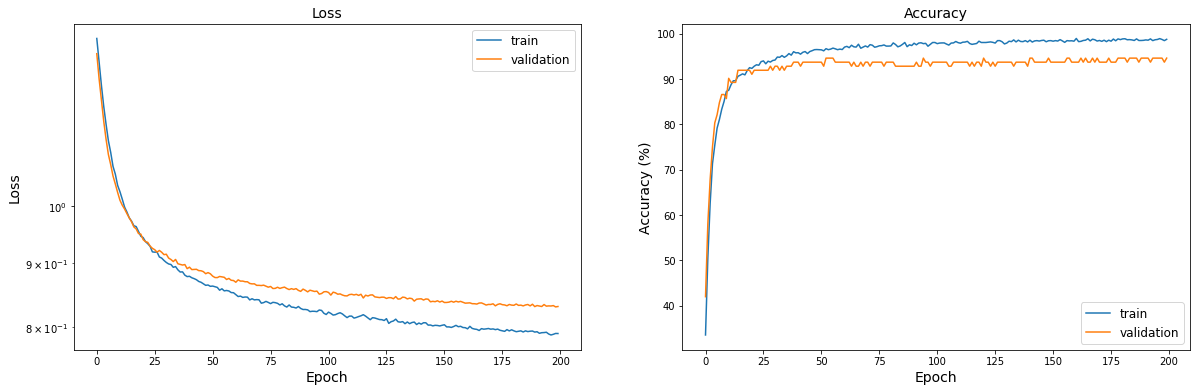

In [15]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# fig.suptitle('Training Curves', fontsize=20)

ax1.plot(train_losses)
ax1.plot(val_losses)
ax1.set_title('Loss', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_yscale('log')
ax1.legend(['train', 'validation'], loc = 'upper right', fontsize=12)

ax2.plot(np.multiply(train_accs,100))
ax2.plot(np.multiply(val_accs,100))
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
# plt.yscale('log')
ax2.legend(['train', 'validation'], loc = 'lower right', fontsize=12)

plt.show()

**Test model**

In [34]:
# Load saved network weights
model = Classifier()
model.to(dev)
model.load_state_dict(torch.load('/content/drive/My Drive/WeatherClassificationModels/classifier_200'))
model.eval()

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=25088, out_features=64, bias=True)
  (relu3): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=64, out_features=4, bias=True)
  (softm): Softmax(dim=1)
)

In [42]:
# Test model on testing dataset
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0
confusion_matrix = np.zeros((len(classes), len(classes)))

with torch.no_grad():
    for images, labels in test_dl:
        predictions = model(conv_network(images)[4])
        confidence, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Analyse errors for per-class accuracy and confusion matrix
        for true_label, pred_label in zip(labels, predicted):
            if true_label == pred_label:
                correct_pred[classes[true_label]] += 1
            total_pred[classes[true_label]] += 1
            confusion_matrix[true_label, pred_label] += 1

# Calculate per-class accuracy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

print('----------------------------------------')
print('Network Accuracy: {:.2f} %'.format(100 * correct / total))
print('----------------------------------------')
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy()))

Accuracy for class Cloudy is: 98.5 %
Accuracy for class Rain  is: 100.0 %
Accuracy for class Shine is: 95.8 %
Accuracy for class Sunrise is: 98.6 %
----------------------------------------
Network Accuracy: 98.23 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        68
           1       1.00      1.00      1.00        36
           2       1.00      0.96      0.98        48
           3       0.97      0.99      0.98        74

    accuracy                           0.98       226
   macro avg       0.99      0.98      0.98       226
weighted avg       0.98      0.98      0.98       226



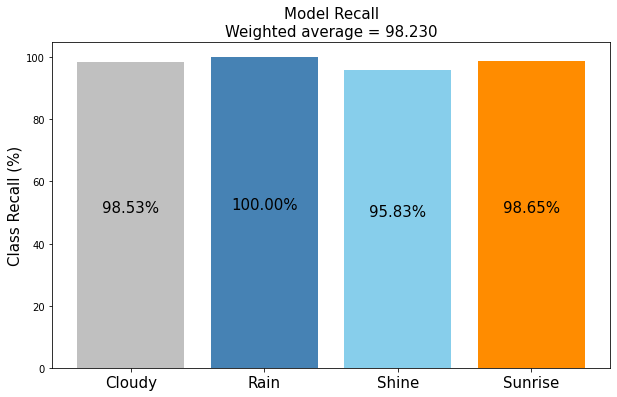

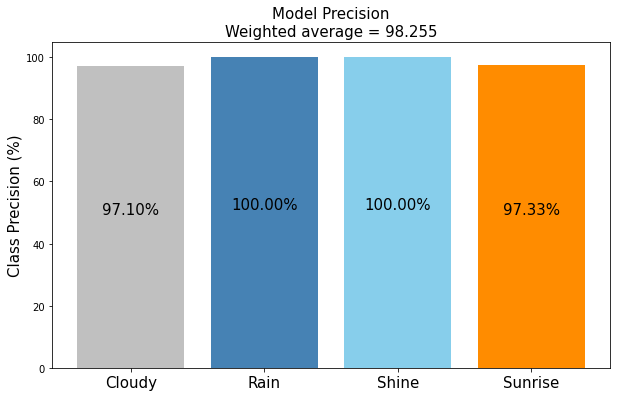

In [70]:
# Plot recall as bar chart
bar_labels = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
recalls = np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, recalls, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(recalls[i]), xy=(bar_labels[i],recalls[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Recall (%)', fontsize='15')
ax.set_title('Model Recall\nWeighted average = {:.3f}'.format(np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

# Plot precision as bar chart
precs = np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, precs, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(precs[i]), xy=(bar_labels[i],precs[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Precision (%)', fontsize='15')
ax.set_title('Model Precision\nWeighted average = {:.3f}'.format(np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

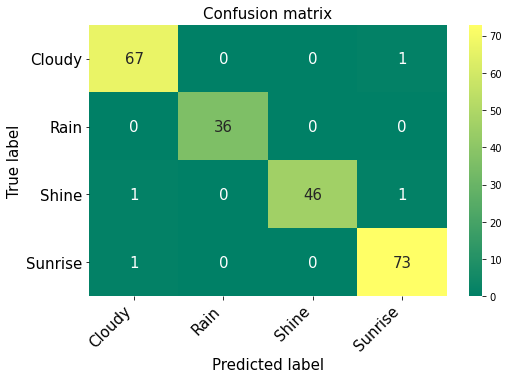

In [16]:
# Plot confusion matrix
plt.figure(figsize=(8,5))

class_names = list(classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, cmap='summer', annot=True, annot_kws={"size":15}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.title('Confusion matrix', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

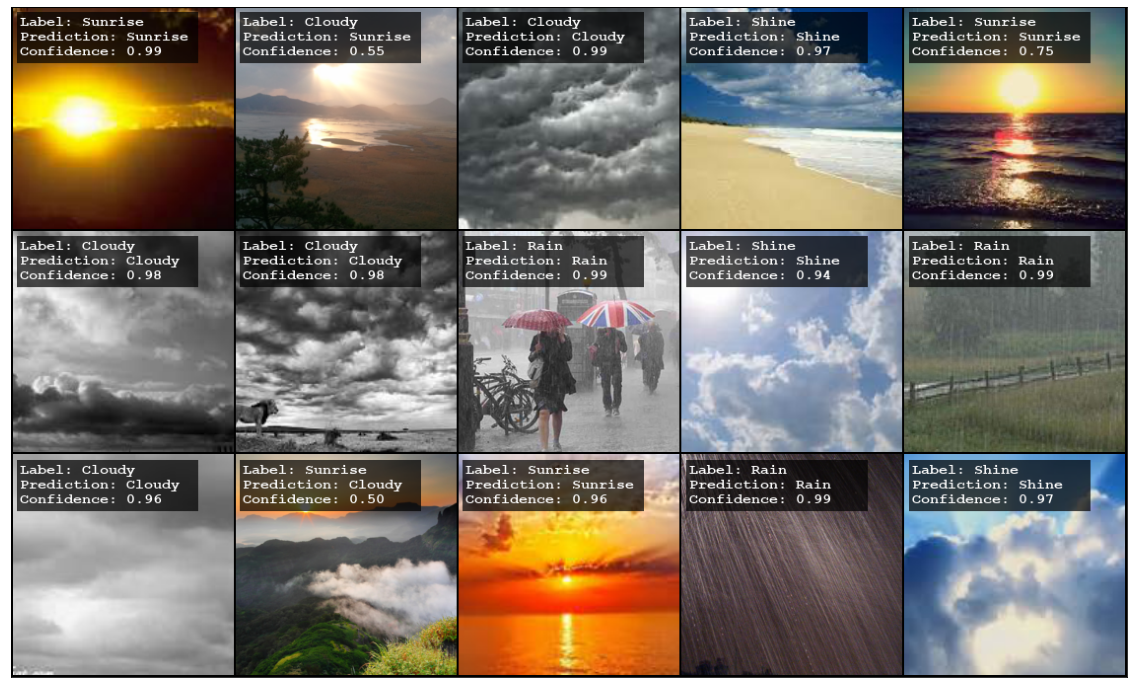

In [17]:
# Display example test images with labels, predictions and confidence
grid_img = to_pil_image(torchvision.utils.make_grid(images[:15], nrow=5))
width, height = grid_img.size
font = ImageFont.truetype("Courier New.ttf", 15)
draw = ImageDraw.Draw(grid_img, 'RGBA')

# Size of rectangles behind text
x_border = 180
y_border = 50

i = 0
for row in range(1,3+1):
  for col in range(1,5+1):
  
    x = width*col/5 - width/5 * 0.96
    y = height*row/3 - 219

    # Rectangle behind text for readabilty
    draw.rectangle((x-3, y-1, x + x_border, y + y_border), fill=(0,0,0,180))

    # Display labels, predictions, confidence
    pred_msg = 'Prediction: {}'.format(classes[predicted[i]])
    conf_msg = 'Confidence: {:.2f}'.format(confidence[i])
    lab_msg = 'Label: {}'.format(classes[labels[i]])
    draw.text((x,y), lab_msg, fill='white', font=font)
    draw.text((x,y+15), pred_msg, fill='white', font=font)
    draw.text((x,y+30), conf_msg, fill='white', font=font)

    i+=1

plt.figure(figsize=(20,20))
plt.imshow(grid_img)
plt.xticks([])
plt.yticks([])
plt.show()